In [1]:
from wrapper_functions import *

2023-02-26 18:36:13.662640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2023-02-26 18:36:28.060447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment II: 2D Spatial Field

### Model Configs

In [ ]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [ ]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .5 # @param
bma_gp_l2_regularizer = 0.7 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [ ]:
# BNE parameters.
bne_gp_lengthscale = .06 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

### Read training/prediction data

In [ ]:
training_eastMA = pd.read_csv('./data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('./data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('./data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, training_eastMA_folds.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('./data/training_dataset/training51.csv')

In [ ]:
# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

In [ ]:
base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




In [ ]:
# Assemble into configs.
from distutils.log import debug


bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

In [ ]:
display(bma_model_config, map_config, mcmc_config)

### Build model

In [ ]:
bma_prior, bma_gp_config = bma_dist(X_train1, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

In [ ]:
def run_posterior_inference(model_dist: tfd.Distribution, 
                            Y: tf.Tensor, 
                            mcmc_config: Dict[str, Any], 
                            map_config: Optional[Dict[str, Any]] = None, 
                            model_config: Optional[Dict[str, Any]] = None,
                            initialize_from_map: bool = True):
  """Wrapper function for running MCMC with MAP initialization."""
  # Defines posterior log likelihood function, and also a 
  # randomly-sampled initial state from model prior.
  nchain = mcmc_config['nchain']
  init_state, target_log_prob_fn = prepare_mcmc(model_dist, Y, nchain=nchain)  
  
  if initialize_from_map:
    # Initializes at MAP, shape (num_chains, param_shape_0, param_shape_1).
    print('Running MAP:', end='\t')
    init_state = run_map(target_log_prob_fn=target_log_prob_fn, 
                         gp_config=model_config,
                         **map_config)

    init_state = tf.stack([init_state] * mcmc_nchain, axis=0)

  # Run MCMC, shape (param_shape_0, param_shape_1, num_chains).
  print('Running MCMC:', end='\t')
  gp_w_samples, chain_samples, sampler_stat = run_mcmc(init_state=init_state,
                             target_log_prob_fn=target_log_prob_fn,
                             debug_mode=True,
                             **mcmc_config)  
  
  return gp_w_samples, chain_samples, sampler_stat

In [ ]:
# display(bma_model_config, map_config,mcmc_config, bma_prior)

### Run MCMC

In [ ]:
bma_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

# Above the debug mode

# bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
#                                            model_config=bma_model_config,
#                                            Y=Y_train, 
#                                            map_config=map_config,
#                                            mcmc_config=mcmc_config)


bma_joint_samples = make_bma_samples(X_test1, None, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)



In [ ]:
plt.plot(chain_samples[:, 8, 1011, 2], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

In [ ]:
#np.mean((means_pred - means_true)**2) / np.var(means_true)
# mse = tf.reduce_mean((means_train_mcmc-Y_train_mcmc)** 2)/ np.var(Y_train_mcmc)
# mse
def rmse(y_obs, y_pred):
    return np.sqrt(np.mean((y_obs - y_pred) ** 2))
bma_mcmc_rmse = rmse(means_train_mcmc, Y_train_mcmc)

reg = LinearRegression().fit(X_train1, Y_train)
y_pred = reg.predict(X_train1)
rmse_lr = mean_squared_error(y_true=Y_train, y_pred=y_pred, squared=False)
display(rmse_lr, bma_mcmc_rmse)

### Prepare Data for BAE/BNE

In [ ]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train1, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test1, None, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

In [ ]:
display(means_train_mcmc.shape, X_train_mcmc.shape, Y_train_mcmc.shape, means_test_mcmc.shape)

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [ ]:
# # # BNE GP Configs.
# # lengthscale = 1. # @param
# # l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param
# # MAP and MCMC configs
# map_step_size=0.1 # @param
# map_num_steps=10_000 # @param

# mcmc_step_size=1e-2 # @param
# mcmc_num_steps=10_000 # @param

bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=bne_gp_lengthscale, 
                          l2_regularizer=bne_gp_l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

### Build Model

In [ ]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

In [ ]:
display(bne_prior, bne_model_config, map_config, mcmc_config)

### Run MCMC

In [ ]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

In [ ]:
plt.plot(chain_samples[:, 9, 791, 1], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

### 10-fold cross validation check

In [2]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .55 # @param
bma_gp_l2_regularizer = .8 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


# BNE parameters.
bne_gp_lengthscale = .05 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param


# ### Read training/prediction data
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')

print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)


base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)


# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             #activation='relu',
                             activation_func='softmax'))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


In [ ]:
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True) 

rmse_lr = []
rmse_gam = []
rmse_bma = []

nll_lr, nll_gam, nll_bma = [], [], []

# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr = 0
coverage_gam = 0
coverage_bma = 0

import rpy2
#from rpy2.robjects import pandas2ri
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.conversion import localconverter
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv  = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')


#ref_model = LinearRegression()
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True) 


for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index] 
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape, base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI
      
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula('aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) & (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, np.asanyarray(lr_pred).reshape(-1,1)))
    nll_lr.append(nll(Y_te, np.asanyarray(lr_pred).reshape(-1,1)))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a= ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) & (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, np.asanyarray(gam_pred).reshape(-1,1)))
    nll_gam.append(nll(Y_te, np.asanyarray(gam_pred).reshape(-1,1)))
    print(rmse_gam)

    # build model & run MCMC
    #fixed_input_tr = tf.ones((X_tr.shape[0], 2), dtype=tf.float32)
    bma_prior, bma_gp_config = bma_dist(X_tr, 
                                    base_preds_tr, 
                                    **bma_model_config)

    bma_model_config.update(bma_gp_config)


    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_tr, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

    #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    raw_error["lon"] = X_te[:,0]
    raw_error["lat"] = X_te[:,1]
    raw_error["raw_error"] = (y_pred - Y_te).numpy().reshape(-1)
    error_df = error_df.append(raw_error)

    pred_std = calc_prediction_std(y_pred, Y_te)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(), (pred_mean + 1.96*pred_std).numpy()])
    coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) & (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    rmse_bma.append(rmse(Y_te, y_pred))
    nll_bma.append(nll(Y_te, y_pred))
    print(rmse_bma)
    # Investigate what examples (e.g., in terms of spatial coordinate) tend to receive high error.

  

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA: ", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))

lr_s = ['', str(np.mean(rmse_lr)), str(np.std(rmse_lr))]
gam_s = ['', str(np.mean(rmse_gam)), str(np.std(rmse_gam))]
bma_s = [ str(np.mean(rmse_bma)), str(np.std(rmse_bma))]

print(error_df)

In [ ]:
# change error_df lon and lat to un normalized values
plt_df = error_df.copy()
plt_df["lon"] = plt_df["lon"] * X_scale[0] + X_centr[0]
plt_df["lat"] = plt_df["lat"] * X_scale[1] + X_centr[1]
# abs error
plt_df["abs_error"] = abs(plt_df["raw_error"])
# plot error_df ordered by abs raw_error
plt_df = plt_df.sort_values(by=['abs_error'])
plt_df = plt_df.reset_index(drop=True)
plt.figure(figsize=(10, 8))
plt.scatter(plt_df["lon"], plt_df["lat"], c=plt_df["abs_error"],
            s=abs(plt_df["raw_error"])*100, cmap='inferno_r')
cbar = plt.colorbar()
# larger points are more error
coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)

# limitation x y axis from coordinate
plt.xlim(min(coordinate[:,0]), max(coordinate[:,0]))
plt.ylim(min(coordinate[:,1]), max(coordinate[:,1]))

# plt_df.plot.scatter(x='lon', y='lat', c='abs_error', s=abs(plt_df["raw_error"])*100,
#                       colormap='inferno_r', figsize=(10, 8))

plt.show()


In [ ]:
# extract the worst predictions and find them in the original dataset "training_eastMA_noMI"
# change error_df lon and lat to un normalized values
plt_df5 = error_df.copy()

plt_df5["abs_error"] = abs(plt_df5["raw_error"])
# plot error_df ordered by abs raw_error
plt_df5 = plt_df5.sort_values(by=['abs_error'])
plt_df5 = plt_df5.reset_index(drop=True)

df6 = plt_df5.tail(10).round(5)

df6["lon"] = df6["lon"].astype(float).round(5)
# show them in the original dataset
training_eastMA_noMI.loc[training_eastMA_noMI['lon'].round(
    5) == df6["lon"].iloc[1]]
df5 = pd.DataFrame(columns=training_eastMA_noMI.columns)
for i in range(len(df6)):
    df5 = df5.append(
    training_eastMA_noMI.loc[training_eastMA_noMI['lon'].round(
        5) == df6["lon"].iloc[i]])

df5

In [ ]:
plt_df5.tail(10)


In [ ]:
# index the third/ten fold of the data
rmse_bma_check = []
coverage_bma_check = 0

for i, (train_index, test_index) in enumerate(kf.split(X_train1)):
    if i == 2 or i == 9:
        X_tr, X_te = X_train1[train_index], X_train1[test_index]
        Y_tr, Y_te = Y_train[train_index], Y_train[test_index]
        
        base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
        print(train_index, test_index)
        # build model & run MCMC
        #fixed_input_tr = tf.ones((X_tr.shape[0], 2), dtype=tf.float32)
        r_dat_py = training_eastMA_noMI
      
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
            r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

        # Ref: lr
        lr_model = stats.lm(ro.Formula('aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
        l = ciTools.add_pi(r_te, lr_model)
        lr_pred = l[7]


         # Ref: GAM
        #df = training_eastMA_noMI.iloc[train_index]
        gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
        a= ciTools.add_pi(r_te, gam_model)
        gam_pred = a[7]


        bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

        bma_model_config.update(bma_gp_config)

        bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

        #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
        bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
        y_pred = bma_joint_samples['y']
        y_pred = tf.reduce_mean(y_pred, axis=0)
        print("true value", Y_te.T)
        print("BMA prediction", y_pred.numpy().T)
        print("LR prediction", lr_pred)
        print("GAM prediction", gam_pred)
        pred_std = calc_prediction_std(y_pred, Y_te)
        print("pred_std", pred_std)
        pred_mean = tf.reduce_mean(y_pred, axis=1)
        print("pred_mean",pred_mean)
        bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
        print(bma_pi)
        coverage_bma_check += np.sum([(Y_te[i] > bma_pi[0][i]) &
                           (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
        print("coverage", coverage_bma_check)
        rmse_bma_check.append(rmse(Y_te, y_pred))
    
print(rmse_bma_check)        
        

In [ ]:
# Plot out distribution of RMSE error to understand why median RMSE << mean RMSE.
plt.figure(figsize=(10, 6))
plt.hist(rmse_lr, bins=20, alpha=0.5, label='LR')
plt.hist(rmse_gam, bins=20, alpha=0.5, label='GAM')
plt.hist(rmse_bma, bins=20, alpha=0.5, label='BMA')
plt.legend(loc='upper right')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE')
plt.show()
# Plot out distribution of NLL error to understand why median NLL << mean NLL.
plt.figure(figsize=(10, 6))
plt.hist(nll_lr, bins=20, alpha=0.5, label='LR')
plt.hist(nll_gam, bins=20, alpha=0.5, label='GAM')
plt.hist(nll_bma, bins=20, alpha=0.5, label='BMA')
plt.legend(loc='upper right')
plt.title('Distribution of NLL')
plt.show()

In [3]:
# use BAE as the 1st step
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .55 # @param
bma_gp_l2_regularizer = .3 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


# BNE parameters.
bne_gp_lengthscale = .05 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param


# ### Read training/prediction data
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')

print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)


base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)


# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             #activation='relu',
                             activation_func='softmax'))
print(bma_model_config)

bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=False,
                n_samples_eval=bma_n_samples_eval,
                n_samples_train=bma_n_samples_train,
                n_samples_test=bma_n_samples_test,
                seed=bma_seed)
print(bma_config)



# BNE parameters.
bne_gp_lengthscale = 7.5  # 5. # @param
bne_gp_l2_regularizer = 10  # 15 # @param
bne_variance_prior_mean = -2.5  # @param
bne_skewness_prior_mean = -2.5  # @param
bne_seed = 0  # @param
bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
                  seed=bne_seed)

print(bne_config)

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))



pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]
{'lengthscale': 0.55, 'l2_regularizer': 0.3, 'hidden_units': 128, 'y_noise_std': 0.01, 'activation_func': 'softmax'}
{'gp_lengthscale': 0.55, 'gp_l2_regularizer': 0.3, 'y_noise_std': 0.01, 'map_step_size': 0.0005, 'map_num_steps': 10000, 'mcmc_step_size': 0.0001, 'mcmc_num_steps': 1000, 'mcmc_initialize_from_map': False, 'n_samples_eval': 250, 'n_samples_train': 100, 'n_samples_test': 250, 'seed': 0}
{'gp_lengthscale': 7.5, 'gp_l2_regularizer': 10, 'variance_prior_mean': -2.5, 'skewness_prior_mean': -2.5, 'map_step_size': 0.0005, 'map_num_steps': 10000, 'mcmc_step_size': 0.0001, 'mcmc_num_steps': 1000, 'mcmc_nchain': 10, 'mcmc_burnin': 2500, 'mcmc_initialize_from_map': True, 'seed': 0}


In [ ]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)

rmse_lr = []
rmse_gam = []
rmse_bma = []
rmse_bae = []
rmse_bma2 = []
rmse_bma_mean = []


nll_lr, nll_gam, nll_bma_mean, nll_bma, nll_bae = [], [], [], [], []
nll_bma2 = []
# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr, coverage_gam, coverage_bma_mean, coverage_bma, coverage_bae = 0, 0, 0, 0, 0
coverage_bma2 = 0
#from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (
      training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (
      training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')


kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)
rmse_bma_mean, rmse_bma2, rmse_bae = [], [], []
for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index]
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy(
    )[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,
          base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula(
        'aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) &
                          (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, np.asanyarray(lr_pred).reshape(-1, 1)))
    nll_lr.append(nll(Y_te, np.asanyarray(lr_pred).reshape(-1, 1)))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula(
        'aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a = ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) &
                           (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, np.asanyarray(gam_pred).reshape(-1, 1)))
    nll_gam.append(nll(Y_te, np.asanyarray(gam_pred).reshape(-1, 1)))
    print(rmse_gam)

    bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

    bma_model_config.update(bma_gp_config)

    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

        #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    
    print("BMA prediction", y_pred.numpy().T)
    print("LR prediction", lr_pred)
    print("GAM prediction", gam_pred)
    pred_std = calc_prediction_std(y_pred, Y_te)
    print("pred_std", pred_std)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    print("pred_mean",pred_mean)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
    print(bma_pi)
    rmse_bma.append(rmse(Y_te, y_pred))
    nll_bma2.append(nll(Y_te, y_pred))
    coverage_bma2 += np.sum([(Y_te[i] > bma_pi[0][i]) & (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
                            
    # Create data dictionary.
    data_dicts = dict(X_train=X_tr,
                      X_test=X_te,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(
        data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(
        bma_mean_joint_samples['y']), axis=0)
    pred_std = calc_prediction_std(y_pred_bma_mean, Y_te)
    bma_mean_pi = np.array([(y_pred_bma_mean - 1.96*pred_std).numpy(), (y_pred_bma_mean + 1.96*pred_std).numpy()])
    print(y_pred_bma_mean)

    # BMA.
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_std = calc_prediction_std(y_pred_bma, Y_te)
    bma_pi2 = np.array([(y_pred_bma - 1.96*pred_std).numpy(), (y_pred_bma + 1.96*pred_std).numpy()])

    # BAE.
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_std = calc_prediction_std(y_pred_bae, Y_te)
    bae_pi = np.array([(y_pred_bae - 1.96*pred_std).numpy(), (y_pred_bae + 1.96*pred_std).numpy()])
    
    # save the rmse & nll for each fold
    rmse_bma_mean.append(rmse(Y_te, y_pred_bma_mean))
    nll_bma_mean.append(nll(Y_te, y_pred_bma_mean))
    rmse_bma2.append(rmse(Y_te, y_pred_bma))
    nll_bma.append(nll(Y_te, y_pred_bma))
    rmse_bae.append(rmse(Y_te, y_pred_bae))
    nll_bae.append(nll(Y_te, y_pred_bae))
   
    # save the coverage for each fold
    coverage_bma_mean += np.sum([(Y_te[i] > bma_mean_pi[0][i]) & (Y_te[i] < bma_mean_pi[1][i]) for i in range(len(Y_te))])
    coverage_bma += np.sum([(Y_te[i] > bma_pi2[0][i]) & (Y_te[i] < bma_pi2[1][i]) for i in range(len(Y_te))])
    coverage_bae += np.sum([(Y_te[i] > bae_pi[0][i]) & (Y_te[i] < bae_pi[1][i]) for i in range(len(Y_te))])
    
    raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    raw_error["lon"] = X_te[:,0]
    raw_error["lat"] = X_te[:,1]
    raw_error["raw_error"] = (y_pred_bae - Y_te).reshape(-1)
    error_df = error_df.append(raw_error)
    print("rmse:", flush=True)
    print(rmse_bma_mean, rmse_bma2, rmse_bae)
    print("nll:", flush=True)
    print(nll_bma_mean, nll_bma, nll_bae)

    # raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    # raw_error["lon"] = X_te[:, 0]
    # raw_error["lat"] = X_te[:, 1]
    # raw_error["raw_error"] = (y_pred - Y_te).numpy().reshape(-1)
    # error_df = error_df.append(raw_error)

    # pred_std = calc_prediction_std(y_pred, Y_te)
    # pred_mean = tf.reduce_mean(y_pred, axis=1)
    # bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
    #                   (pred_mean + 1.96*pred_std).numpy()])
    # coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) &
    #                        (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    # rmse_bma.append(rmse(Y_te, y_pred))
    # nll_bma.append(nll(Y_te, y_pred))
    # print(rmse_bma)
    # Investigate what examples (e.g., in terms of spatial coordinate) tend to receive high error.

# # save rmse average among folds
# average_metrics = np.mean(
#     [rmse_bma_mean, rmse_bma2, rmse_bae], axis=1)
# print(average_metrics)

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA-mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA: ", np.mean(rmse_bma2), np.median(rmse_bma2), np.std(rmse_bma2))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA-mean: ", np.mean(nll_bma_mean), np.median(nll_bma_mean), np.std(nll_bma_mean))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))
print("NLL BAE: ", np.mean(nll_bae), np.median(nll_bae), np.std(nll_bae))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA-mean: ", coverage_bma_mean/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))
print("Coverage BAE: ", coverage_bae/len(Y_train))

print("coverage bma 2", flush=True)
print(coverage_bma2/len(Y_train))

In [ ]:

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA: ", np.mean(rmse_bma2), np.median(rmse_bma2), np.std(rmse_bma2))
print("RMSE BMA-Mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA:", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("RMSE BMA-Mean: ", rmse_bma_mean)
print("RMSE BMA:", rmse_bma)
print("RMSE BAE: ", rmse_bae)


### check cross-validation NLL at each location (y_true-y_pred)^2/pred_var

In [4]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)

nll_lr_each, nll_gam_each, nll_bma_mean_each, nll_bma_each, nll_bae_each = [], [], [], [], []
nll_bma2_each = []
# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr, coverage_gam, coverage_bma_mean, coverage_bma, coverage_bae = 0, 0, 0, 0, 0
coverage_bma2 = 0
#from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (
      training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (
      training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')

kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)
rmse_bma_mean, rmse_bma2, rmse_bae = [], [], []
for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index]
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy(
    )[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,
          base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula(
        'aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    nll_lr_each = np.append(nll_lr_each, nll_each(Y_te.T, lr_pred).numpy())
    

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula(
        'aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a = ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    nll_gam_each = np.append(nll_gam_each, nll_each(Y_te.T, gam_pred).numpy())

    bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

    bma_model_config.update(bma_gp_config)

    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    nll_bma2_each = np.append(nll_bma2_each, nll_each(Y_te, y_pred))
    
    print("BMA prediction", y_pred.numpy().T)
    print("LR prediction", lr_pred)
    print("GAM prediction", gam_pred)
    pred_std = calc_prediction_std(y_pred, Y_te)
    print("pred_std", pred_std)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    print("pred_mean",pred_mean)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
       
    # Create data dictionary.
    data_dicts = dict(X_train=X_tr,
                      X_test=X_te,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(
        data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(
        bma_mean_joint_samples['y']), axis=0)
    pred_std = calc_prediction_std(y_pred_bma_mean, Y_te)
    bma_mean_pi = np.array([(y_pred_bma_mean - 1.96*pred_std).numpy(), (y_pred_bma_mean + 1.96*pred_std).numpy()])
    nll_bma_mean_each = np.append(nll_bma_mean_each, nll_each(Y_te, y_pred_bma_mean))

    # BMA.
    print('BMA:', flush=True)
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_std = calc_prediction_std(y_pred_bma, Y_te)
    bma_pi2 = np.array([(y_pred_bma - 1.96*pred_std).numpy(), (y_pred_bma + 1.96*pred_std).numpy()])
    nll_bma_each = np.append(nll_bma_each, nll_each(Y_te, y_pred_bma))

    # BAE.
    print('BAE:', flush=True)
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_std = calc_prediction_std(y_pred_bae, Y_te)
    bae_pi = np.array([(y_pred_bae - 1.96*pred_std).numpy(), (y_pred_bae + 1.96*pred_std).numpy()])
    nll_bae_each = np.append(nll_bae_each, nll_each(Y_te, y_pred_bae))
    

    # raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    # raw_error["lon"] = X_te[:, 0]
    # raw_error["lat"] = X_te[:, 1]
    # raw_error["raw_error"] = (y_pred - Y_te).numpy().reshape(-1)
    # error_df = error_df.append(raw_error)

    # pred_std = calc_prediction_std(y_pred, Y_te)
    # pred_mean = tf.reduce_mean(y_pred, axis=1)
    # bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
    #                   (pred_mean + 1.96*pred_std).numpy()])
    # coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) &
    #                        (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    # rmse_bma.append(rmse(Y_te, y_pred))
    # nll_bma.append(nll(Y_te, y_pred))
    # print(rmse_bma)
    # Investigate what examples (e.g., in terms of spatial coordinate) tend to receive high error.

# # save rmse average among folds
# average_metrics = np.mean(
#     [rmse_bma_mean, rmse_bma2, rmse_bae], axis=1)
# print(average_metrics)

/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[ 0  1  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 2 10 11 22 28 29]
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
activation function used softmax
Running MAP:	350461.09375...198691.1875...190832.859375...187353.203125...184630.78125...181759.5625...178917.34375...175890.84375...172838.859375...169946.59375...Done.
Running MCMC:	Acceptance Ratio: 0.7646586298942566
activation function used softmax
BMA prediction [[10.000861   9.70002    6.5334682  9.207447   6.0986733  9.199912 ]]
LR prediction [1] 10.122534  9.868970  5.900925  9.721513  5.350043  9.428457

GAM prediction [1] 10.211692  9.819234  5.673587  9.639126  5.343896  9.012283

pred_std tf.Tensor(0.46581557, shape=(), dtype=float32)
pred_mean tf.Tensor([10.000861   9.70002    6.5334682  9.207447   6.0986733  9.199912 ], shape=(6,), dtype=float32)
[[9.97563  ]
 [9.837391 ]
 [6.332692 ]
 [9.2525   ]
 [5.0865545]
 [8.473109 ]]
BMA-mean:
activ

In [5]:
print("Average nll lr each", np.mean(nll_lr_each))
print("Average nll gam each", np.mean(nll_gam_each))
print("Average nll bma mean each", np.mean(nll_bma_mean_each))
print("Average nll bma each", np.mean(nll_bma_each))
print("Average nll bae each", np.mean(nll_bae_each))


print("Average nll bma2 each", np.mean(nll_bma2_each))

Average nll lr each 0.9550289047948158
Average nll gam each 1.1748984383307022
Average nll bma mean each 1.0554246676483137
Average nll bma each 1.0126111915736806
Average nll bae each 0.9710674476571816
Average nll bma2 each 1.0275837300692265


### Plot the NLL for each points

In [7]:
# with localconverter(ro.default_converter + pandas2ri.converter):
#   # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
#   training_eastMA_noMI["lon"] = (training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
#   training_eastMA_noMI["lat"] = (training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
#   r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)

# mgcv  = importr('mgcv')
# stats = importr('stats')
# ciTools = importr('ciTools')

# initialize a dataframe to store lon, lat and raw error
plt_nll = pd.DataFrame(columns=["lon", "lat", 'nll_lr_each', 'nll_gam_each', 'nll_bma_mean_each', 'nll_bma_each', 'nll_bae_each', 'nll_bma2_each'])


for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index] 
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]

    plt_nll1 = pd.DataFrame(columns=["lon", "lat", 'nll_lr_each', 'nll_gam_each', 'nll_bma_mean_each', 'nll_bma_each', 'nll_bae_each', 'nll_bma2_each'])
    plt_nll1["lon"] = X_te[:,0]
    plt_nll1["lat"] = X_te[:,1]

    plt_nll = plt_nll.append(plt_nll1)

In [27]:
# show plt_nll ordered by nll_bae_each
plt_nll_bae_ordered = plt_nll.sort_values(by=['nll_bae_each'], ascending=False)
plt_nll_bae_ordered


,lon,lat,nll_lr_each,nll_gam_each,nll_bma_mean_each,nll_bma_each,nll_bae_each,nll_bma2_each
3,-71.054298,42.363098,4.675364,5.688762,4.499996,4.799508,5.944819,2.714047
4,-72.309502,43.629604,1.704004,4.649697,5.200092,4.879830,4.217529,5.159675
0,-73.057541,40.827991,3.439215,3.395332,4.895314,4.636311,4.038561,3.367921
4,-72.334076,42.298492,0.324999,0.365824,5.433719,4.799132,3.781025,4.721010
3,-71.458244,43.132462,2.075898,2.453726,2.374775,2.573790,3.117440,2.316143
2,-72.909798,42.956100,2.694988,3.568449,3.211759,3.179438,3.024578,3.141648
2,-73.255089,42.452019,3.625768,3.020306,2.437898,2.581256,2.944196,2.118666
1,-71.379974,41.874668,0.958114,2.665127,1.347926,1.484198,2.105429,1.505760
2,-72.590805,42.108994,0.003058,0.018180,1.219598,1.494170,1.937786,1.243393
5,-71.082603,42.329498,4.272517,1.605875,2.588356,2.500003,1.708540,2.434474


In [8]:
# change plt_nll lon and lat to un normalized values
plt_nll["lon"] = plt_nll["lon"] * X_scale[0] + X_centr[0]
plt_nll["lat"] = plt_nll["lat"] * X_scale[1] + X_centr[1]
# plt_nll other columns
plt_nll["nll_lr_each"] = nll_lr_each
plt_nll["nll_gam_each"] = nll_gam_each
plt_nll["nll_bma_mean_each"] = nll_bma_mean_each
plt_nll["nll_bma_each"] = nll_bma_each
plt_nll["nll_bae_each"] = nll_bae_each
plt_nll["nll_bma2_each"] = nll_bma2_each


In [ ]:
# nll_color_list = np.append(nll_lr_each, nll_gam_each)
# nll_color_list = np.append(nll_color_list, nll_bma_mean_each)
# nll_color_list = np.append(nll_color_list, nll_bma_each)
# nll_color_list = np.append(nll_color_list, nll_bae_each)
np.log(nll_color_list.reshape(len(nll_color_list), -1)+1)

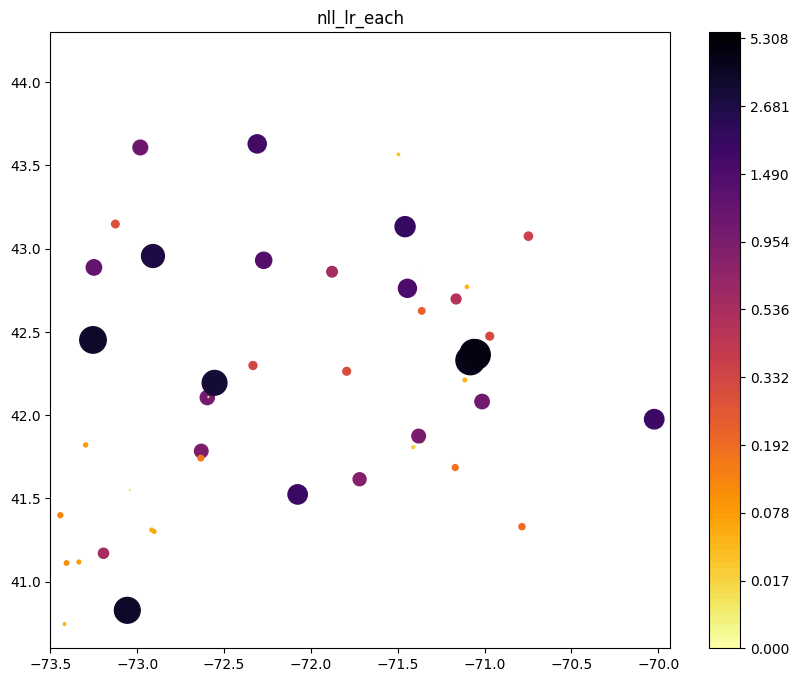

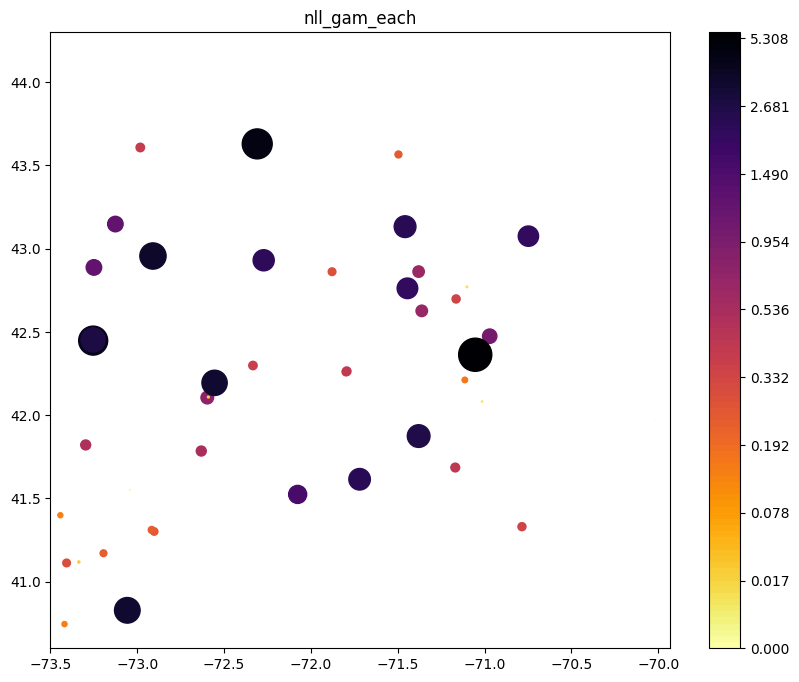

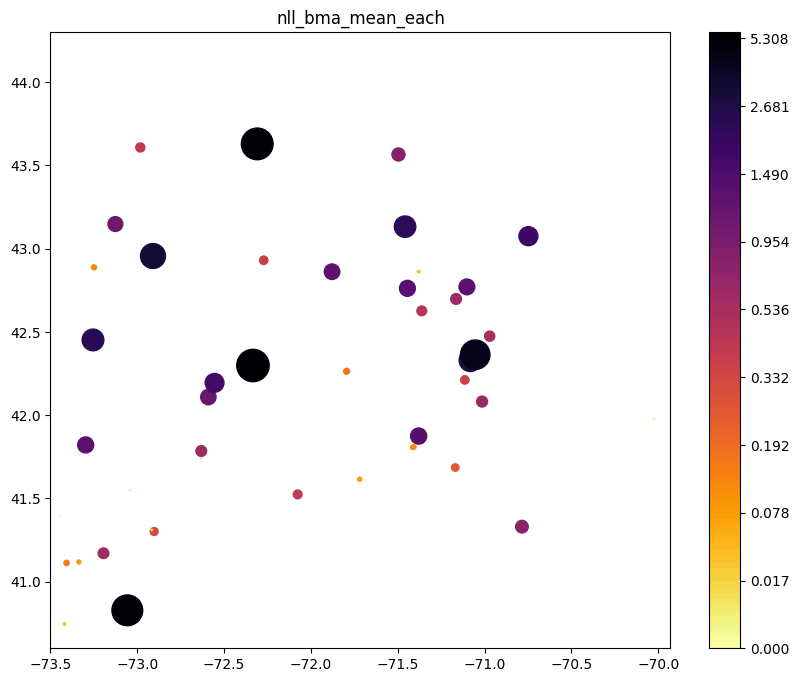

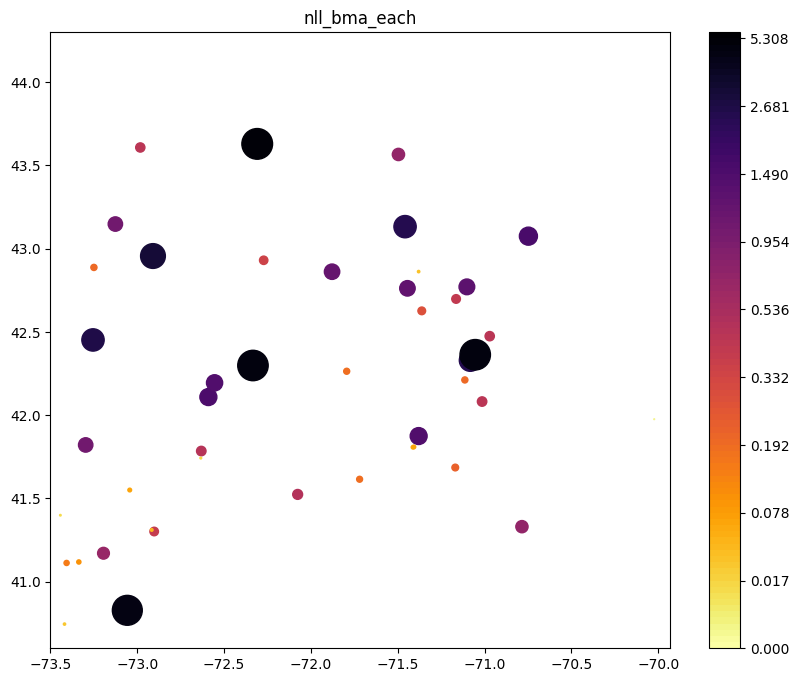

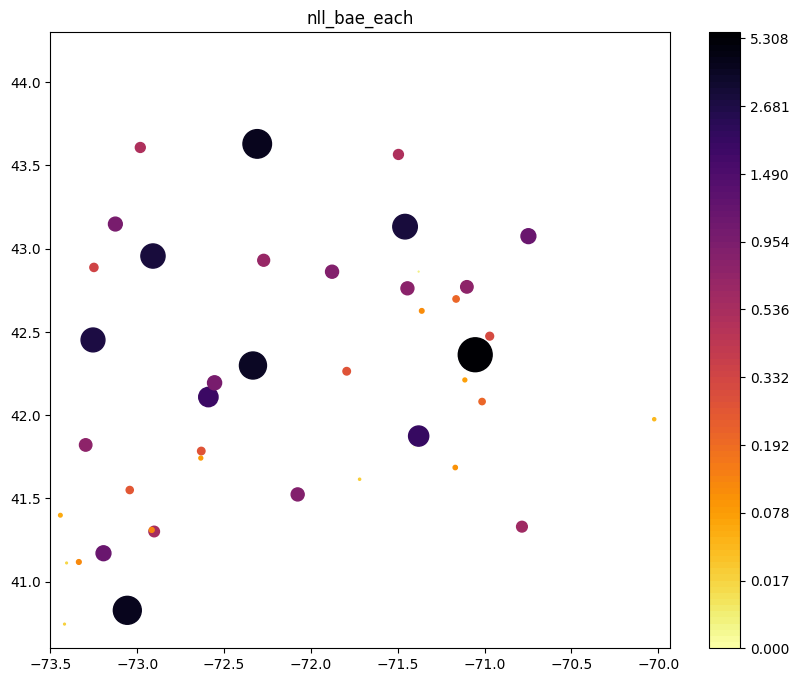

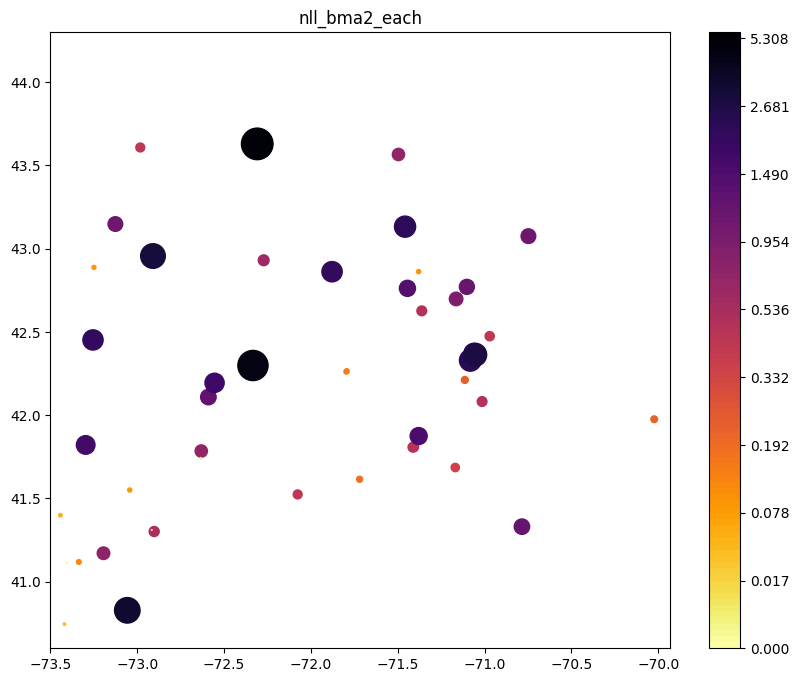

In [42]:

color_norm_nll_each = make_color_norm(
    nll_color_list.reshape(len(nll_color_list), -1),
    method='percentile')

for i in ["nll_lr_each", "nll_gam_each", "nll_bma_mean_each", "nll_bma_each", "nll_bae_each", "nll_bma2_each"]:
    # log scale colorbar
    plt.figure(figsize=(10, 8))
    plt.scatter(plt_nll["lon"], plt_nll["lat"], c=plt_nll[i], 
                s=abs(plt_nll[i])*100, cmap='inferno_r', norm=color_norm_nll_each)
    
    cbar = plt.colorbar()
    # plt.scatter(plt_nll["lon"], plt_nll["lat"], c=plt_nll[i],
    #             s=abs(plt_nll[i])*50, cmap='inferno_r', norm=color_norm_nll_each)
    

    # larger points are more error
    coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)

    # limitation x y axis from coordinate
    plt.xlim(min(coordinate[:,0]), max(coordinate[:,0]))
    plt.ylim(min(coordinate[:,1]), max(coordinate[:,1]))
    plt.title(i)
    plt.show()



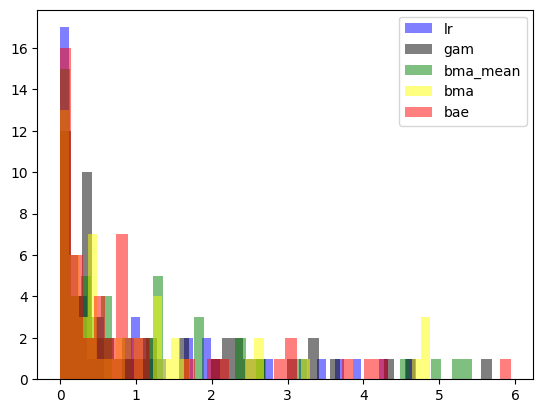

In [16]:
# use histogram to show the distribution of nll
plt.hist(nll_lr_each, bins=40, color='blue', alpha=0.5, label='lr')
plt.hist(nll_gam_each, bins=40, color='black', alpha=0.5, label='gam')
plt.hist(nll_bma_mean_each, bins=40, color='green', alpha=0.5, label='bma_mean')
plt.hist(nll_bma_each, bins=40, color='yellow', alpha=0.5, label='bma')
plt.hist(nll_bae_each, bins=40, color='red', alpha=0.5, label='bae')

plt.legend(loc='upper right')
plt.show()


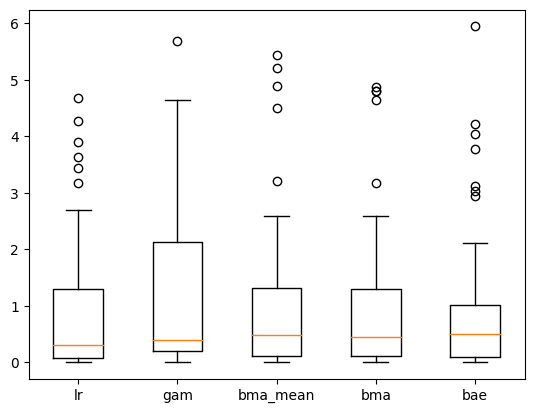

,lr,gam,bma_mean,bma,bae
0.05,0.003863,0.001740,0.006369,0.014904,0.000950
0.25,0.071080,0.197964,0.104131,0.114492,0.102158
0.5,0.310231,0.400264,0.488557,0.448680,0.508847
0.75,1.291155,2.125512,1.317591,1.303108,1.007613
0.95,3.764705,3.963713,4.697655,4.717722,3.909793


In [26]:
# use boxplot to visualize the distribution of nll for each model
plt.boxplot([nll_lr_each, nll_gam_each, nll_bma_mean_each, nll_bma_each, nll_bae_each],
            labels=['lr', 'gam', 'bma_mean', 'bma', 'bae'])
plt.show()

# table to show the mean, median and std of nll for each model

nll_lr_each_mean = np.mean(nll_lr_each)
nll_lr_each_median = np.median(nll_lr_each)
nll_lr_each_std = np.std(nll_lr_each)

nll_gam_each_mean = np.mean(nll_gam_each)
nll_gam_each_median = np.median(nll_gam_each)
nll_gam_each_std = np.std(nll_gam_each)

nll_bma_mean_each_mean = np.mean(nll_bma_mean_each)
nll_bma_mean_each_median = np.median(nll_bma_mean_each)
nll_bma_mean_each_std = np.std(nll_bma_mean_each)

nll_bma_each_mean = np.mean(nll_bma_each)
nll_bma_each_median = np.median(nll_bma_each)
nll_bma_each_std = np.std(nll_bma_each)

nll_bae_each_mean = np.mean(nll_bae_each)
nll_bae_each_median = np.median(nll_bae_each)
nll_bae_each_std = np.std(nll_bae_each)

table_nll = pd.DataFrame(
    {"lr": [nll_lr_each_mean, nll_lr_each_median, nll_lr_each_std],
        "gam": [nll_gam_each_mean, nll_gam_each_median, nll_gam_each_std],
        "bma_mean": [nll_bma_mean_each_mean, nll_bma_mean_each_median, nll_bma_mean_each_std],
        "bma": [nll_bma_each_mean, nll_bma_each_median, nll_bma_each_std],
        "bae": [nll_bae_each_mean, nll_bae_each_median, nll_bae_each_std]},
    index=["mean", "median", "std"]
)

#  quantile of nll for each model

nll_lr_each_quantile = np.quantile(nll_lr_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_gam_each_quantile = np.quantile(nll_gam_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_bma_mean_each_quantile = np.quantile(nll_bma_mean_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_bma_each_quantile = np.quantile(nll_bma_each, [0.05, 0.25, 0.5, 0.75, 0.95])
nll_bae_each_quantile = np.quantile(nll_bae_each, [0.05, 0.25, 0.5, 0.75, 0.95])

table_nll_quantile = pd.DataFrame(
    {"lr": nll_lr_each_quantile,
        "gam": nll_gam_each_quantile,
        "bma_mean": nll_bma_mean_each_quantile,
        "bma": nll_bma_each_quantile,
        "bae": nll_bae_each_quantile},
    index=["0.05", "0.25", "0.5", "0.75", "0.95"]
)
table_nll_quantile
